**Group 8: Yu-Fang Liao, Han Nga Chan, Yumeng Tang**
---

This notebook focuses on implementing **CNN**, including **custom CNN**, **ResNet18-based modifications**, and **ResNet50-based modifications**, for face recognition tasks.

# **1. Install and import necessary packages and libraries**

In [ ]:
#pip install matplotlib

In [ ]:
#pip install -U scikit-learn scipy matplotlib

In [ ]:
#pip install tensorflow

In [ ]:
#pip install torch torchvision

In [ ]:
# use torch-summary for more info on the model
#!pip install torchinfo

In [ ]:
#pip install wandb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil
import warnings
from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import random
import matplotlib.image as mpimg
import torchvision.models as models
from torchinfo import summary
import wandb
from wandb.keras import WandbCallback
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix

2024-04-25 10:07:55.121895: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 10:07:55.173126: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 10:07:56.795486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# suppress display of warnings
warnings.filterwarnings('ignore')

In [3]:
enable_wandb = True
use_gpu = True

In [4]:
gpu_available = torch.cuda.is_available()
gpu_available

True

In [5]:
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yfliao (unice-yfl). Use `wandb login --relogin` to force relogin


## **2. Data Preparation**

In [6]:
# # Unzip the 105_classes_pins_dataset.zip file
# import zipfile
# with zipfile.ZipFile("105_classes_pins_dataset.zip","r") as zip_ref:
#     zip_ref.extractall("img")

In [7]:
# # Unzip the bollywood.zip
# with zipfile.ZipFile("bollywood.zip","r") as zip_ref:
#     zip_ref.extractall("img")

In [8]:
# Only need to be done once
""" 
# Move all the folders in bollywood_celeb_faces_0 to all_img_folder
source = 'img/bollywood/bollywood_celeb_faces_0'
destination = 'img/all_img_folder/'
 
# gather all files
allfiles = os.listdir(source)
 
# iterate on all files to move them to destination folder
for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    shutil.move(src_path, dst_path)

# Move all the folders in bollywood_celeb_faces_1 to the all_img_folder
source = 'img/bollywood/bollywood_celeb_faces_1'
destination = 'img/all_img_folder/'
 
# gather all files
allfiles = os.listdir(source)
 
# iterate on all files to move them to destination folder
for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    shutil.move(src_path, dst_path)

# Move all the folders in bollywood_celeb_faces2 to the all_img_folder
source = 'img/bollywood/bollywood_celeb_faces2'
destination = 'img/all_img_folder/'
 
# gather all files
allfiles = os.listdir(source)
 
# iterate on all files to move them to destination folder
for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    shutil.move(src_path, dst_path)


# Move all the folders in 105_classes_pins_dataset to the all_img_folder
source = 'img/105_classes_pins_dataset'
destination = 'img/all_img_folder/'
 
# gather all files
allfiles = os.listdir(source)
 
# iterate on all files to move them to destination folder
for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    shutil.move(src_path, dst_path)
"""

" \n# Move all the folders in bollywood_celeb_faces_0 to all_img_folder\nsource = 'img/bollywood/bollywood_celeb_faces_0'\ndestination = 'img/all_img_folder/'\n \n# gather all files\nallfiles = os.listdir(source)\n \n# iterate on all files to move them to destination folder\nfor f in allfiles:\n    src_path = os.path.join(source, f)\n    dst_path = os.path.join(destination, f)\n    shutil.move(src_path, dst_path)\n\n# Move all the folders in bollywood_celeb_faces_1 to the all_img_folder\nsource = 'img/bollywood/bollywood_celeb_faces_1'\ndestination = 'img/all_img_folder/'\n \n# gather all files\nallfiles = os.listdir(source)\n \n# iterate on all files to move them to destination folder\nfor f in allfiles:\n    src_path = os.path.join(source, f)\n    dst_path = os.path.join(destination, f)\n    shutil.move(src_path, dst_path)\n\n# Move all the folders in bollywood_celeb_faces2 to the all_img_folder\nsource = 'img/bollywood/bollywood_celeb_faces2'\ndestination = 'img/all_img_folder/'\n \

List all the folders to double-check their count and the total number of files.

In [5]:
main_directory = 'img/male/'

folder_count = 0
total_file_count = 0

# Iterate through the main directory
for root, dirs, files in os.walk(main_directory):
    folder_count += len(dirs)
    
    # Count files in each folder
    folder_file_count = len(files)
    total_file_count += folder_file_count
    print(f"Folder: {os.path.basename(root)}, Files: {folder_file_count}")
    
print(f"\nNumber of folders: {folder_count}")
print(f"Total number of files: {total_file_count}")

Folder: , Files: 0
Folder: Jason Momoa, Files: 384
Folder: Tom Cruise, Files: 392
Folder: Dwayne Johnson, Files: 341
Folder: Chris Hemsworth, Files: 359
Folder: Mark Zuckerberg, Files: 295
Folder: Johnny Depp, Files: 382
Folder: Robert Downey Jr, Files: 433
Folder: Cristiano Ronaldo, Files: 298
Folder: Tom Hiddleston, Files: 381
Folder: Bill Gates, Files: 322
Folder: Ben Affleck, Files: 326
Folder: Leonardo DiCaprio, Files: 437
Folder: Alvaro Morte, Files: 339
Folder: elon musk, Files: 335
Folder: Jimmy Fallon, Files: 313
Folder: Mark Ruffalo, Files: 378
Folder: Chris Evans, Files: 366
Folder: Tom Holland, Files: 389
Folder: Tom Hardy, Files: 398
Folder: Chris Pratt, Files: 376

Number of folders: 20
Total number of files: 7244


Display the images contained within the folders.

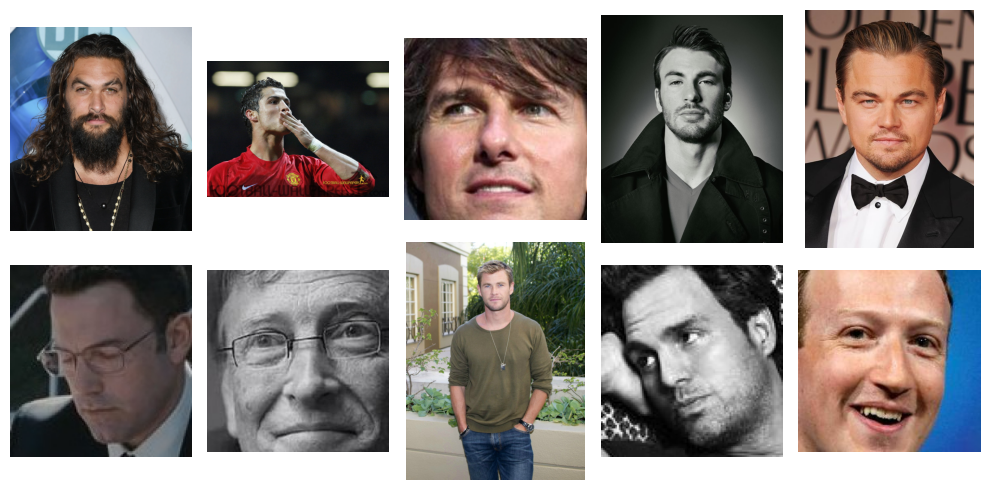

In [10]:
# List of all folders
all_folders = [folder for folder in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, folder))]

# Randomly pick 10 folders
selected_folders = random.sample(all_folders, 10)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, folder in enumerate(selected_folders):
    folder_path = os.path.join(main_directory, folder)
    all_images = [img for img in os.listdir(folder_path) if img.endswith('.jpg')]
    
    # Randomly pick one image
    selected_image = random.choice(all_images)
    image_path = os.path.join(folder_path, selected_image)
    
    img = mpimg.imread(image_path)
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
    
plt.tight_layout()
plt.show()

# **3. Hyper-parameters**

In [8]:
# Hyperparameters configs

# 1st exp
# configs = {
#     "project_name": "Team Project - Face Recognition",
#     "experiment_name": "1st-20230415",
#     "freeze_feature_extraction_layers": True,
#     "pretrained":True,
#     "efficientnet":False,
#     "data_augmentation":False,
#     "transferlearning": True,

#     # Data
#     "img_dimensions" : (3,224,224),
#     "batch_size" : 32,
#     "num_classes" : 205,

#     # CNN
#     "filter_sizes" : [4,8],
#     "kernel_size" : 5,
#     "stride": 2,
#     "padding":1,

#     #Optimzation
#     "learning_rate" : 0.01,
#     "epochs" : 70,
#     "weight_decay" : 0.00001
# }


# # 2nd exp
# configs = {
#     "project_name": "Team Project - Face Recognition",
#     "experiment_name": "2st-20230416",
#     "freeze_feature_extraction_layers": True,
#     "pretrained":True,
#     "efficientnet":False,
#     "data_augmentation":False,
#     "transferlearning": True,

#     # Data
#     "img_dimensions" : (3,224,224),
#     "batch_size" : 32,
#     "num_classes" : 205,

#     # CNN
#     "filter_sizes" : [4,8],
#     "kernel_size" : 3,
#     "stride": 2,
#     "padding":1,

#     #Optimzation
#     "learning_rate" : 0.001,
#     "epochs" : 50,
#     "weight_decay" : 0.00001
# }

# # 3rd exp
# configs = {
#     "project_name": "Team Project - Face Recognition",
#     "experiment_name": "3rd-20230418",
#     "freeze_feature_extraction_layers": False,
#     "pretrained":True,
#     "efficientnet":False,
#     "data_augmentation":True,
#     "transferlearning": True,

#     # Data
#     "img_dimensions" : (3,224,224),
#     "batch_size" : 32,
#     "num_classes" : 205,

#     # CNN
#     "filter_sizes" : [4,8],
#     "kernel_size" : 3,
#     "stride": 2,
#     "padding":1,

#     #Optimzation
#     "learning_rate" : 0.01,
#     "epochs" : 70,
#     "weight_decay" : 0.00001
# }

# # 4th exp --> exp 2's parameters + only 105 class dataset, but the used number of output class as 205
# configs = {
#     "project_name": "Team Project - Face Recognition",
#     "experiment_name": "4th-20230418",
#     "freeze_feature_extraction_layers": True,
#     "pretrained":True,
#     "efficientnet":False,
#     "data_augmentation":False,
#     "transferlearning": True,

#     # Data
#     "img_dimensions" : (3,224,224),
#     "batch_size" : 32,
#     "num_classes" : 205,

#     # CNN
#     "filter_sizes" : [4,8],
#     "kernel_size" : 3,
#     "stride": 2,
#     "padding":1,

#     #Optimzation
#     "learning_rate" : 0.001,
#     "epochs" : 50,
#     "weight_decay" : 0.00001
# }

# # 5th exp --> same as 4th exp, number of output class as 105
# configs = {
#     "project_name": "Team Project - Face Recognition",
#     "experiment_name": "6th-20230418",
#     "freeze_feature_extraction_layers": True,
#     "pretrained":True,
#     "efficientnet":False,
#     "data_augmentation":False,
#     "transferlearning": True,

#     # Data
#     "img_dimensions" : (3,224,224),
#     "batch_size" : 32,
#     "num_classes" : 105,

#     # CNN
#     "filter_sizes" : [4,8],
#     "kernel_size" : 3,
#     "stride": 2,
#     "padding":1,

#     #Optimzation
#     "learning_rate" : 0.001,
#     "epochs" : 50,
#     "weight_decay" : 0.00001
# }

# # 7th exp --> exp 5's parameters + combine dataset + output = 105 --> didn't finish due to time up for SCC
# configs = {
#     "project_name": "Team Project - Face Recognition",
#     "experiment_name": "7th-20230421",
#     "freeze_feature_extraction_layers": True,
#     "pretrained":True,
#     "efficientnet":False,
#     "data_augmentation":False,
#     "transferlearning": True,

#     # Data
#     "img_dimensions" : (3,224,224),
#     "batch_size" : 32,
#     "num_classes" : 105,

#     # CNN
#     "filter_sizes" : [4,8],
#     "kernel_size" : 3,
#     "stride": 2,
#     "padding":1,

#     #Optimzation
#     "learning_rate" : 0.001,
#     "epochs" : 50,
#     "weight_decay" : 0.00001
# }


# # 8th exp ResNet50 + epochs = 30 + learning rate = 0.01
# configs = {
#     "project_name": "Team Project - Face Recognition",
#     "experiment_name": "8th-20230421",
#     "freeze_feature_extraction_layers": True,
#     "pretrained":True,
#     "efficientnet":False,
#     "data_augmentation":False,
#     "transferlearning": True,

#     # Data
#     "img_dimensions" : (3,224,224),
#     "batch_size" : 32,
#     "num_classes" : 105,

#     # CNN
#     "filter_sizes" : [4,8],
#     "kernel_size" : 3,
#     "stride": 2,
#     "padding":1,

#     #Optimzation
#     "learning_rate" : 0.01,
#     "epochs" : 30,
#     "weight_decay" : 0.00001
# }

# # 9th exp ResNet50+layers + data_augmentation + epochs = 50 +weight_decay = 0.0001
# configs = {
#     "project_name": "Team Project - Face Recognition",
#     "experiment_name": "9th-20230422",
#     "freeze_feature_extraction_layers": True,
#     "pretrained":True,
#     "efficientnet":False,
#     "data_augmentation":True,
#     "transferlearning": True,

#     # Data
#     "img_dimensions" : (3,224,224),
#     "batch_size" : 32,
#     "num_classes" : 105,

#     # CNN
#     "filter_sizes" : [4,8],
#     "kernel_size" : 3,
#     "stride": 2,
#     "padding":1,

#     #Optimzation
#     "learning_rate" : 0.01,
#     "epochs" : 50,
#     "weight_decay" : 0.0001
# }

# # 16th exp --> dataset = male --> num_classes = 20, epcho = 10, ResNet50 + layer 
# configs = {
#     "project_name": "Team Project - Face Recognition",
#     "experiment_name": "16th-20230423-male-epoch10",
#     "freeze_feature_extraction_layers": True,
#     "pretrained":True,
#     "efficientnet":False,
#     "data_augmentation":True,
#     "transferlearning": True,

#     # Data
#     "img_dimensions" : (3,224,224),
#     "batch_size" : 32,
#     "num_classes" : 20,

#     # CNN
#     "filter_sizes" : [4,8],
#     "kernel_size" : 3,
#     "stride": 2,
#     "padding":1,

#     #Optimzation
#     "learning_rate" : 0.001,
#     "epochs" : 10,
#     "weight_decay" : 0.00001
# }

# # 20th exp --> dataset = male --> num_classes = 20, epcho = 10, ResNet50 + layer  + learning_rate = 0.01
# configs = {
#     "project_name": "Team Project - Face Recognition",
#     "experiment_name": "20th-20230424-male-epoch10-ResNet50",
#     "freeze_feature_extraction_layers": True,
#     "pretrained":True,
#     "efficientnet":False,
#     "data_augmentation":True,
#     "transferlearning": True,

#     # Data
#     "img_dimensions" : (3,224,224),
#     "batch_size" : 32,
#     "num_classes" : 20,

#     # CNN
#     "filter_sizes" : [4,8],
#     "kernel_size" : 3,
#     "stride": 2,
#     "padding":1,

#     #Optimzation
#     "learning_rate" : 0.01,
#     "epochs" : 10,
#     "weight_decay" : 0.00001
# }

# # 21th exp --> dataset = female --> num_classes = 20, epcho = 10, ResNet50 + layer  + learning_rate = 0.01
# configs = {
#     "project_name": "Team Project - Face Recognition",
#     "experiment_name": "21th-20230424-female-epoch10-ResNet50",
#     "freeze_feature_extraction_layers": True,
#     "pretrained":True,
#     "efficientnet":False,
#     "data_augmentation":True,
#     "transferlearning": True,

#     # Data
#     "img_dimensions" : (3,224,224),
#     "batch_size" : 32,
#     "num_classes" : 20,

#     # CNN
#     "filter_sizes" : [4,8],
#     "kernel_size" : 3,
#     "stride": 2,
#     "padding":1,

#     #Optimzation
#     "learning_rate" : 0.01,
#     "epochs" : 10,
#     "weight_decay" : 0.00001
# }

# # 22th exp --> dataset = female --> num_classes = 20, epcho = 10, ResNet50 + layer  + learning_rate = 0.01
# configs = {
#     "project_name": "Team Project - Face Recognition",
#     "experiment_name": "22th-20230424-female-epoch10-ResNet50-tuning",
#     "freeze_feature_extraction_layers": True,
#     "pretrained":True,
#     "efficientnet":False,
#     "data_augmentation":True,
#     "transferlearning": True,

#     # Data
#     "img_dimensions" : (3,224,224),
#     "batch_size" : 32,
#     "num_classes" : 20,

#     # CNN
#     "filter_sizes" : [4,8],
#     "kernel_size" : 3,
#     "stride": 2,
#     "padding":1,

#     #Optimzation
#     "learning_rate" : 0.01,
#     "epochs" : 10,
#     "weight_decay" : 0.00001
# }


# # Best Model 0424
# configs = {
#     "project_name": "Team Project - Face Recognition",
#     "experiment_name": "Best Model 0424",
#     "freeze_feature_extraction_layers": True,
#     "pretrained":True,
#     "efficientnet":False,
#     "data_augmentation":True,
#     "transferlearning": True,

#     # Data
#     "img_dimensions" : (3,224,224),
#     "batch_size" : 32,
#     "num_classes" : 20,

#     # CNN
#     "filter_sizes" : [4,8],
#     "kernel_size" : 3,
#     "stride": 2,
#     "padding":1,

#     #Optimzation
#     "learning_rate" : 0.01,
#     "epochs" : 10,
#     "weight_decay" : 0.00001
# }

# Customized CNN 0424
configs = {
    "project_name": "Team Project - Face Recognition",
    "experiment_name": "Customized CNN 0424",
    "freeze_feature_extraction_layers": False,
    "pretrained":True,
    "efficientnet":True,
    "data_augmentation":True,
    "transferlearning": True,

    # Data
    "img_dimensions" : (3,224,224),
    "batch_size" : 32,
    "num_classes" : 20,

    # CNN
    "filter_sizes" : [4,8],
    "kernel_size" : 3,
    "stride": 2,
    "padding":1,

    #Optimzation
    "learning_rate" : 0.01,
    "epochs" : 10,
    "weight_decay" : 0.00001
}

# **4. Transformation**

We defined a series of transformations for our dataset, including random horizontal flipping, resizing, random cropping, random rotation, color jittering, conversion to PyTorch tensor format, and normalization using the mean and standard deviation of the ImageNet dataset. If data augmentation is enabled, these transformations are applied with specific probabilities; otherwise, a subset of them is applied. We utilized the ImageFolder class from torchvision to load the dataset, split it into training, validation, and test sets, and created corresponding data loaders for each set with specified batch sizes and shuffling configurations.

In [12]:
# Transformations
if configs["data_augmentation"]:
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(0.5), # 50% of the person will flip
      transforms.Resize(224),       # Resize the image to 224x224 pixels while maintaining aspect ratio
      transforms.RandomCrop(224),
      transforms.RandomRotation(45),
      transforms.ColorJitter(),
      transforms.ToTensor(),               # Convert the image to a PyTorch tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the tensor using the mean and
                      std=[0.229, 0.224, 0.225])       # standard deviation of the ImageNet dataset
  ])
else:
  transform = transforms.Compose([
      transforms.Resize(224),       # Resize the image to 224x224 pixels while maintaining aspect ratio
      transforms.CenterCrop(224),
      transforms.ToTensor(),               # Convert the image to a PyTorch tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the tensor using the mean and
                      std=[0.229, 0.224, 0.225])       # standard deviation of the ImageNet dataset
  ])


import torchvision
whole_dataset = torchvision.datasets.ImageFolder(main_directory, transform=transform)
train_dataset, val_dataset = random_split(whole_dataset, [0.7, 0.3])
test_dataset, val_dataset = random_split(val_dataset, [0.5, 0.5])

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=configs["batch_size"], shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=configs["batch_size"], shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=configs["batch_size"], shuffle=False)

In [13]:
train_dataset[0][0]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

# **5. Model**

## **< Model 1: CNN>**

We designed a convolutional neural network (CNN) comprising two convolutional blocks, global average pooling, and a fully connected classifier. 

In [36]:
# Reference: https://www.kaggle.com/code/haneenhossam/fashion-mnist-cnn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

class CNN(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,  # Assuming the input has 3 channels
                      out_channels=configs['filter_sizes'][0],
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=configs['filter_sizes'][0],
                      out_channels=configs['filter_sizes'][0],
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=configs['filter_sizes'][0]),
            nn.MaxPool2d(kernel_size=2))

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=configs['filter_sizes'][0],
                      out_channels=configs['filter_sizes'][1],
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=configs['filter_sizes'][1],
                      out_channels=configs['filter_sizes'][1],
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=configs['filter_sizes'][1]),
            nn.MaxPool2d(kernel_size=2))

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=configs['filter_sizes'][1],
                      out_features=num_classes))

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x

model = CNN(num_classes=configs['num_classes'])
print(model)

CNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8, out_features=20, bias=True)
  )
)


## **< Model 2: ResNet18 + CNN>**

On the ResNet18 model, we replaced the original fully connected layer (fc) with a new sequence of layers comprising a linear layer followed by a ReLU activation function and another linear layer. This adjustment was made to adapt the network to our specific number of output classes, enhancing its suitability for our classification task.

In [9]:
# CNN model
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            torch.nn.Conv2d(configs["img_dimensions"][0], configs["filter_sizes"][0], configs["kernel_size"], stride=configs["stride"], padding=configs["padding"]),
            torch.nn.ReLU(),
            torch.nn.Conv2d(configs["filter_sizes"][0], configs["filter_sizes"][1], configs["kernel_size"], stride=configs["stride"], padding=configs["padding"]),
            torch.nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(72, output_size)
        )

    # Forward pass.
    def forward(self, x):
        x = x.view(-1, configs["img_dimensions"][0], configs["img_dimensions"][1], configs["img_dimensions"][2])
        return self.model(x)

In [10]:
if configs["transferlearning"]:
  # Load a pre-trained ResNet-18 model
  if not configs["efficientnet"]:
    model = models.resnet18(pretrained=configs["pretrained"])
  else:
    model = torch.hub.load("pytorch/vision", "efficientnet_b2", weights="EfficientNet_B2_Weights.IMAGENET1K_V1")
else:
  model = CNN(configs["num_classes"])

if gpu_available and use_gpu:
  model = model.cuda()

Using cache found in /usr4/ba820/yfliao/.cache/torch/hub/pytorch_vision_main


In [11]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
# Replace the last layer
if configs["transferlearning"]:
  if configs["efficientnet"]:
    model.classifier[1] = torch.nn.Sequential(torch.nn.Linear(1408, 100), torch.nn.ReLU(), torch.nn.Linear(100, configs["num_classes"]))
  else:
    model.fc = torch.nn.Sequential(torch.nn.Linear(512, 100), torch.nn.ReLU(), torch.nn.Linear(100, configs["num_classes"]))  # The name of the layer is fc --> remove the original layer and add these to the layer
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
# Freeze other layers
if configs["transferlearning"]:
  if configs["freeze_feature_extraction_layers"]==True:
    # Freeze all layers except the last fully connected layer
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last fully connected layer
    if configs["efficientnet"]:
      for param in model.classifier[1].parameters():
          param.requires_grad = True
    else:
      for param in model.fc.parameters():
          param.requires_grad = True

In [14]:
# Sanity Check
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 20]                   --
├─Sequential: 1-1                                       [1, 1408, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    │    └─MBConv: 3-5                                 [1, 16, 112, 112]         612
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-6                                

## **< Model 3: ResNet50 + CNN>**

On the ResNet50 model, we made several changes. First, we replaced the original fully connected layer (fc) with a new linear layer, adapting the output size to match the number of classes in our classification task. Additionally, we modified the number of input features for the new fully connected layer to match the output of the ResNet50 backbone, which is 2048. Furthermore, if specified, we froze the feature extraction layers of the model to prevent them from being updated during training, ensuring that only the new fully connected layer is trained. 

In [12]:
# Pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze the feature extraction part of the model if needed
if configs["freeze_feature_extraction_layers"]:
    for param in model.parameters():
        param.requires_grad = False

# Modify the fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, configs["num_classes"])

# Move model to GPU if CUDA is available
if use_gpu and gpu_available:
    model = model.cuda()

In [13]:
import torchvision.models as models

if configs["transferlearning"]:
  if not configs["efficientnet"]:
    model = models.resnet50(pretrained=configs["pretrained"])
  else:
    model = torch.hub.load("pytorch/vision", "efficientnet_b2", weights="EfficientNet_B2_Weights.IMAGENET1K_V1")
else:
  model = CNN(configs["num_classes"])

if gpu_available and use_gpu:
  model = model.cuda()

In [14]:
# Replace the last layer
if configs["transferlearning"]:
  if configs["efficientnet"]:
    model.classifier[1] = torch.nn.Sequential(torch.nn.Linear(1408, 100), torch.nn.ReLU(), torch.nn.Linear(100, configs["num_classes"]))
  else:
    model.fc = torch.nn.Sequential(torch.nn.Linear(2048, 100), torch.nn.ReLU(), torch.nn.Linear(100, configs["num_classes"]))  # Change to 2048 (ResNet50)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
# Freeze other layers
if configs["transferlearning"]:
  if configs["freeze_feature_extraction_layers"]==True:
    # Freeze all layers except the last fully connected layer
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last fully connected layer
    if configs["efficientnet"]:
      for param in model.classifier[1].parameters():
          param.requires_grad = True
    else:
      for param in model.fc.parameters():
          param.requires_grad = True

In [16]:
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 20]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (4,096)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]    

# **6. Loss: Cross-Entropy**

In [37]:
criterion = nn.CrossEntropyLoss()

# **7. Optimizer: SGD**

In [38]:
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=configs["learning_rate"], weight_decay=configs["weight_decay"])

# **8. Training**

In [24]:
if enable_wandb:
  wandb.init(
    project=configs["project_name"],
    name=configs["experiment_name"],
    config=configs)

In [39]:
# Calculate accuracy
def get_accuracy(dataloader, model):
  acc = 0
    
  with torch.no_grad():
      for images, labels in dataloader:
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          outputs = model(images) # Predictions
          acc = acc + torch.sum(torch.argmax(outputs, axis=1) == labels) # Update accuracy

      # Compute the accuracy
      acc = acc/len(dataloader.dataset) # normalizes
      return acc

In [40]:
# Calculate the loss
def get_loss(loader):
  with torch.no_grad():

    loss = 0
    for i, (images, labels) in enumerate(loader): # The batches.
          # step1: Move data to cuda
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          # step2: Forward pass
          outputs = model(images)

          # step 3: calculate the loss.
          loss = loss + criterion(outputs, labels)
    return loss/ len(loader)

# **9. Early-stopping**

In [41]:
# EarlyStopper
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        #  Reset the counter if the new loss is lower than the old loss
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            
            # Keep track of the best model by saving it
            torch.save(model.state_dict(), "./Customized_CNN_male.pt")
        
        # otherwise, increment the counter.
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            
            # If there have been too many epochs with the loss being high, terminate.
            if self.counter >= self.patience:
                return True
        return False

# **10. Train!**

In [42]:
if gpu_available and use_gpu:
  model = model.cuda()

In [46]:
early_stopper = EarlyStopper(patience=7)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

# Training loop
for epoch in range(configs["epochs"]): # The epochs.
    for i, (images, labels) in enumerate(train_loader): # The batches.
        # step 1: Zero out the gradients.
        optimizer.zero_grad()

        # step 1.1 move data to cuda. Make sure the model is on cuda too!
        if gpu_available and use_gpu:
          images = images.cuda()
          labels = labels.cuda()

        # step2: Forward pass
        outputs = model(images)

        # step 3: calculate the loss.
        loss = criterion(outputs, labels)

        # step 4: Backward pass
        loss.backward()
        optimizer.step()

        # Print the loss
        if i %100 == 0:
          print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item())
          if enable_wandb:
            wandb.log({"loss": loss})

    # Compute total train accuracy
    train_acc = get_accuracy(train_loader, model)
    test_acc = get_accuracy(val_loader, model)

    validation_loss = get_loss(val_loader)
    wandb.log({"val_loss": validation_loss})

    # Confusion Matrix
    all_ground_truth = []
    all_predictions = []

    # Iterate over the validation dataset to accumulate all the labels and predictions
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in val_loader:
            if gpu_available and use_gpu:
                images = images.cuda()
    
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
    
            all_predictions.extend(preds.cpu().numpy() if use_gpu else preds.numpy())
            all_ground_truth.extend(labels.cpu().numpy() if use_gpu else labels.numpy())

    model.train()  # Set model back to train mode
    
    # Confusion matrix
    conf_mat = confusion_matrix(all_ground_truth, all_predictions)

    print(f'Epoch [{epoch + 1}/{configs["epochs"]}], LR: {optimizer.param_groups[0]["lr"]}, Validation Loss: {validation_loss.item():.4f}, Train Accuracy: {train_acc.item():.4f}, Test Accuracy: {test_acc.item():.4f}')
    if enable_wandb:
      wandb.log({"epoch": epoch + 1, 
                 "LR": {optimizer.param_groups[0]['lr']}, 
                 "train_accuracy": train_acc.item(), 
                 "val_accuracy": test_acc.item(),
                 "confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                 y_true=all_ground_truth,
                                                                 preds=all_predictions,
                                                                 class_names=[str(i) for i in range(configs["num_classes"])]),
                "raw_confusion_matrix": wandb.Table(data=conf_mat.tolist(), columns=[str(i) for i in range(configs["num_classes"])])})
        
    scheduler.step(validation_loss)

    if early_stopper.early_stop(validation_loss):
        print("Validation loss hasn't dropped. Early stopping!")
        break

Epoch 1  batch 1 . Training Loss:  2.9404244422912598
Epoch 1  batch 101 . Training Loss:  2.9890425205230713
Epoch [1/10], LR: 0.01, Validation Loss: 2.9469, Train Accuracy: 0.0892, Test Accuracy: 0.0875
Epoch 2  batch 1 . Training Loss:  2.8922905921936035
Epoch 2  batch 101 . Training Loss:  2.8756706714630127
Epoch [2/10], LR: 0.01, Validation Loss: 2.9407, Train Accuracy: 0.0945, Test Accuracy: 0.0967
Epoch 3  batch 1 . Training Loss:  2.8995397090911865
Epoch 3  batch 101 . Training Loss:  2.952951192855835
Epoch [3/10], LR: 0.01, Validation Loss: 2.9342, Train Accuracy: 0.1020, Test Accuracy: 0.1013
Epoch 4  batch 1 . Training Loss:  2.9952852725982666
Epoch 4  batch 101 . Training Loss:  2.872396945953369
Epoch [4/10], LR: 0.01, Validation Loss: 2.9257, Train Accuracy: 0.0939, Test Accuracy: 0.0856
Epoch 5  batch 1 . Training Loss:  2.98663330078125
Epoch 5  batch 101 . Training Loss:  2.871612071990967
Epoch [5/10], LR: 0.01, Validation Loss: 2.9267, Train Accuracy: 0.1012, Te

# **11. Test**

In [47]:
print("last model performance on Test set:", get_accuracy(test_loader, model))

# Once training is done, load the best model (might not be the last model due to early stopping)
model.load_state_dict(torch.load("./Customized_CNN_male.pt"))
acc = get_accuracy(test_loader, model)
print("best model performance Test set:", acc)

if enable_wandb:
  wandb.summary['Test Accuracy'] = acc.item()

last model performance on Test set: tensor(0.1041, device='cuda:0')
best model performance Test set: tensor(0.1004, device='cuda:0')


In [48]:
if enable_wandb:
  wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▅▃▆▄▄▅▃▂▃▄▅▂▅▂▃▂▂▆▁▄▂▂▁▁
train_accuracy,▁▂▃▂▃▄▄▅██
val_accuracy,▂▃▄▁▄▂▁▄▇█
val_loss,█▇▆▆▅▅▄▄▄▄▃▁▁
Test Accuracy,0.10037
epoch,10
loss,2.81383
train_accuracy,0.12505
val_accuracy,0.12339
val_loss,2.89214


# **12. Hyper Parameter Tuning (Grid Search)**

In [51]:
# Sweep configuration
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.01, 0.1]
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'optimizer': {
            'values': ['Adam', 'SGD']
        }
    }
}

In [49]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train():
    with wandb.init() as run:
        config = wandb.config

        if torch.cuda.is_available():
            model.cuda()

        optimizer = getattr(optim, config.optimizer)(model.parameters(), lr=config.learning_rate)
        criterion = nn.CrossEntropyLoss()
        
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)
        early_stopper = EarlyStopper(patience=3)

        for epoch in range(configs["epochs"]):
            for i, (images, labels) in enumerate(train_loader):
                optimizer.zero_grad()
                if torch.cuda.is_available():
                    images = images.cuda()
                    labels = labels.cuda()

                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                if i % 100 == 0:
                    print(f"Epoch {epoch + 1}, batch {i + 1}. Training Loss: {loss.item()}")
                    if enable_wandb:
                        wandb.log({"loss": loss})

            train_acc = get_accuracy(train_loader, model)
            test_acc = get_accuracy(val_loader, model)
            validation_loss = get_loss(val_loader)
            wandb.log({"val_loss": validation_loss, "epoch": epoch + 1, "LR": optimizer.param_groups[0]['lr'], "train_accuracy": train_acc, "val_accuracy": test_acc})

            all_ground_truth = []
            all_predictions = []
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                for images, labels in val_loader:
                    if gpu_available and use_gpu:
                        images = images.cuda()
            
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
            
                    all_predictions.extend(preds.cpu().numpy() if use_gpu else preds.numpy())
                    all_ground_truth.extend(labels.cpu().numpy() if use_gpu else labels.numpy())
        
            model.train()
            conf_mat = confusion_matrix(all_ground_truth, all_predictions)
            

            print(f'Epoch [{epoch + 1}/{configs["epochs"]}], LR: {optimizer.param_groups[0]["lr"]}, Validation Loss: {validation_loss.item():.4f}, Train Accuracy: {train_acc.item():.4f}, Test Accuracy: {test_acc.item():.4f}')

            if enable_wandb:
                wandb.log({"epoch": epoch + 1, 
                           "LR": optimizer.param_groups[0]['lr'], 
                           "train_accuracy": train_acc.item(), 
                           "val_accuracy": test_acc.item(),
                           "confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                           y_true=all_ground_truth,
                                                                           preds=all_predictions,
                                                                           class_names=[str(i) for i in range(configs["num_classes"])]),
                           "raw_confusion_matrix": wandb.Table(data=conf_mat.tolist(), columns=[str(i) for i in range(configs["num_classes"])])})
        
            scheduler.step(validation_loss)

            # Check for early stopping
            if early_stopper.early_stop(validation_loss):
                print("Validation loss hasn't dropped. Early stopping!")
                break

        # Save the best model
        model.load_state_dict(torch.load("./Customized_CNN_male_tuning.pt"))
        wandb.log({'Test Accuracy': test_acc})

In [ ]:
sweep_id = wandb.sweep(sweep_config, project=configs['project_name'])
wandb.agent(sweep_id, train, count=10)  

Create sweep with ID: e3fspnpt
Sweep URL: https://wandb.ai/unice-yfl/Team%20Project%20-%20Face%20Recognition%20/sweeps/e3fspnpt


wandb: Agent Starting Run: 9gco1zly with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	optimizer: Adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1, batch 1. Training Loss: 2.9104301929473877
Epoch 1, batch 101. Training Loss: 2.7923150062561035
Epoch [1/10], LR: 0.001, Validation Loss: 2.8819, Train Accuracy: 0.1312, Test Accuracy: 0.1298
Epoch 2, batch 1. Training Loss: 2.7407755851745605
Epoch 2, batch 101. Training Loss: 2.8771958351135254
Epoch [2/10], LR: 0.001, Validation Loss: 2.8735, Train Accuracy: 0.1333, Test Accuracy: 0.1289
Epoch 3, batch 1. Training Loss: 2.8040857315063477
Epoch 3, batch 101. Training Loss: 2.7787904739379883
Epoch [3/10], LR: 0.001, Validation Loss: 2.8746, Train Accuracy: 0.1404, Test Accuracy: 0.1363
Epoch 4, batch 1. Training Loss: 2.8011109828948975
Epoch 4, batch 101. Training Loss: 2.7951440811157227
Epoch [4/10], LR: 0.001, Validation Loss: 2.8652, Train Accuracy: 0.1422, Test Accuracy: 0.1372
Epoch 5, batch 1. Training Loss: 2.939248561859131
Epoch 5, batch 101. Training Loss: 2.807372808456421
Epoch [5/10], LR: 0.001, Validation Loss: 2.8581, Train Accuracy: 0.1460, Test Accuracy:

Traceback (most recent call last):
  File "/scratch/6839386.1.batcomputer-pub/ipykernel_141129/2950034560.py", line 77, in train
    model.load_state_dict(torch.load("./Customized_CNN_male_tuning.pt"))
  File "/projectnb/ba865/students/yfliao/venvs/mynewenv/lib/python3.10/site-packages/torch/serialization.py", line 998, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/projectnb/ba865/students/yfliao/venvs/mynewenv/lib/python3.10/site-packages/torch/serialization.py", line 445, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/projectnb/ba865/students/yfliao/venvs/mynewenv/lib/python3.10/site-packages/torch/serialization.py", line 426, in __init__
    super().__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: './Customized_CNN_male_tuning.pt'


LR,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▇▅▃▇▅▄▅▅█▅▇▄▅▄▆▁▆▅▅▂
train_accuracy,▁▁▂▂▄▄▄▄▆▆▅▅▇▇██▇▇██
val_accuracy,▁▁▁▁▃▃▃▃▃▃▄▄██▁▁▆▆▅▅
val_loss,█▇▇▅▄▄▂▁▁▂
LR,0.001
epoch,10
loss,2.69813
train_accuracy,0.15385
val_accuracy,0.14273


Run 9gco1zly errored:
Traceback (most recent call last):
  File "/projectnb/ba865/students/yfliao/venvs/mynewenv/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/scratch/6839386.1.batcomputer-pub/ipykernel_141129/2950034560.py", line 77, in train
    model.load_state_dict(torch.load("./Customized_CNN_male_tuning.pt"))
  File "/projectnb/ba865/students/yfliao/venvs/mynewenv/lib/python3.10/site-packages/torch/serialization.py", line 998, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/projectnb/ba865/students/yfliao/venvs/mynewenv/lib/python3.10/site-packages/torch/serialization.py", line 445, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/projectnb/ba865/students/yfliao/venvs/mynewenv/lib/python3.10/site-packages/torch/serialization.py", line 426, in __init__
    super().__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: './Customized_CNN_male_tuning.pt'


Epoch 1, batch 1. Training Loss: 2.701436996459961
Epoch 1, batch 101. Training Loss: 2.756890058517456


# **Reference:**

1. https://www.kaggle.com/code/vinayakshanawad/celebrity-face-recognition-vggface-model
2. https://stackoverflow.com/questions/3451111/unzipping-files-in-python
3. https://www.geeksforgeeks.org/how-to-move-all-files-from-one-directory-to-another-using-python/
4. https://www.kaggle.com/code/alkanerturan/facedetection-recognition/notebook
5. https://www.kaggle.com/code/saeedghamshadzai/face-rec-cnn-tf-acc-71-52
6. https://www.v7labs.com/blog/train-validation-test-set
7. https://www.kaggle.com/code/sandy1112/create-and-train-resnet50-from-scratch
8. https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
9. https://blackdev.medium.com/face-recognition-using-cnn-based-on-resnet50-architecture-for-small-dataset-e54ea318cc3e
10. https://www.kaggle.com/code/archisha26/face-detection-and-resnet-50
11. https://github.com/KaihuaTang/ResNet50-Pytorch-Face-Recognition
12. https://github.com/ishaanjav/Python-ML-Facial-Recognition
13. https://github.com/topics/hyperparameter-tuning
14. https://github.com/ammahmoudi/Face-Recognition
15. https://github.com/saint1729/coursera/blob/master/deep-learning/convoutional-neural-networks/week4/Face_Recognition.ipynb
16. https://github.com/elhamod/BA865-2024/tree/main/hands-on